In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# BDT packages
import xgboost as xgb
import lightgbm as lgb

In [19]:
### Set default plot parameters

# Font and fontsize
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Grid
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.color'] = 'white'
plt.rcParams['axes.grid'] = True

# Background color
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'gainsboro'
plt.rcParams['savefig.facecolor'] = 'white'

# Legend background color
plt.rcParams['legend.facecolor'] = 'white'


### Loading The data

In [20]:
# Loading the training data
train_data = pd.read_csv("AppML_InitialProject_train.csv", sep=",")
input_data = train_data.drop(columns=['p_Truth_isElectron', 'p_Truth_Energy'])
truth_data = train_data['p_Truth_isElectron']                                   # Chech only if it is an electron
variables = input_data.columns.tolist()                                         # List of variables used in the model


# Loading the test data (for applying the model)
test_data = pd.read_csv("AppMl_InitialProject_test_classification.csv", sep=",")


# Splitting the training data using sklearn
from sklearn.model_selection import train_test_split
X_train, x_valid, Y_train, y_valid = train_test_split(input_data, truth_data, test_size=0.2, random_state=42)

print(f"Ratio of electons in training data: {Y_train.sum()/len(Y_train):.2f} ({Y_train.sum()} electrons)")  

Ratio of electons in training data: 0.21 (30326 electrons)


### Running a LGBM Boosted desicion tree model on all variables:

In [21]:

model = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="binary",
    metric="binary_logloss",
    num_leaves=10,
    verbose=0,
    n_estimators=500,
    early_stopping_rounds=20
)

# Fitting the model
model.fit(X_train, Y_train, eval_set=[(x_valid, y_valid)])

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20


LGBMClassifier(early_stopping_rounds=20, metric='binary_logloss',
               n_estimators=500, num_leaves=10, objective='binary', verbose=0)

### Determining the most important parameters - LGBM feature ranking and SHAP-values

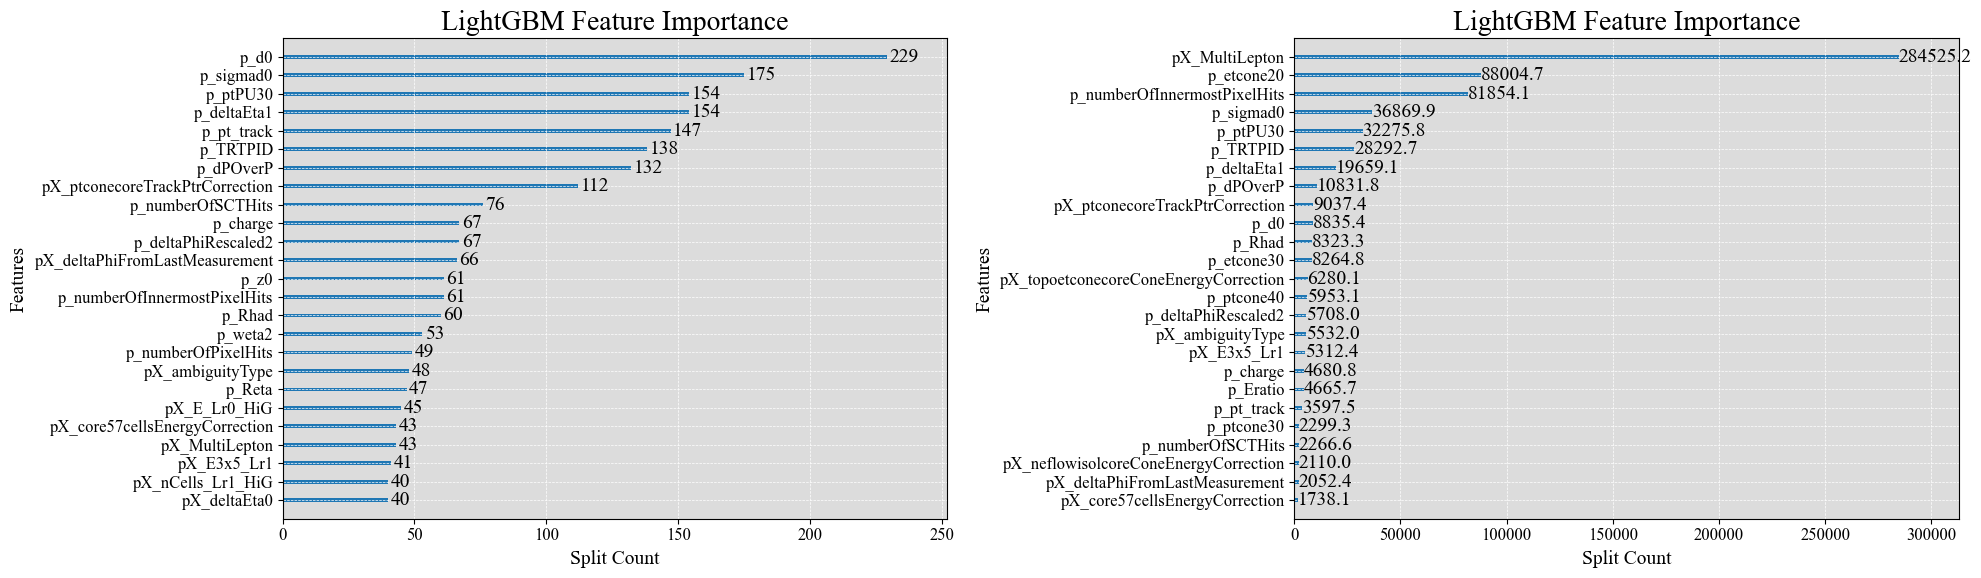

In [22]:
# LightGBM feature importance

fig, ax = plt.subplots(1,2,figsize=(20, 6))

lgb.plot_importance(
    model,
    max_num_features=25,
    importance_type="split",
    title="LightGBM Feature Importance",
    ax=ax[0],
    xlabel="Split Count",
    ylabel="Features",
    figsize=(10, 6),
    precision=1,
)
lgb.plot_importance(
    model,
    max_num_features=25,
    importance_type="gain",
    title="LightGBM Feature Importance",
    xlabel="Split Count",
    ax=ax[1],
    ylabel="Features",
    figsize=(10, 6),
    precision=1

)

plt.tight_layout()

/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


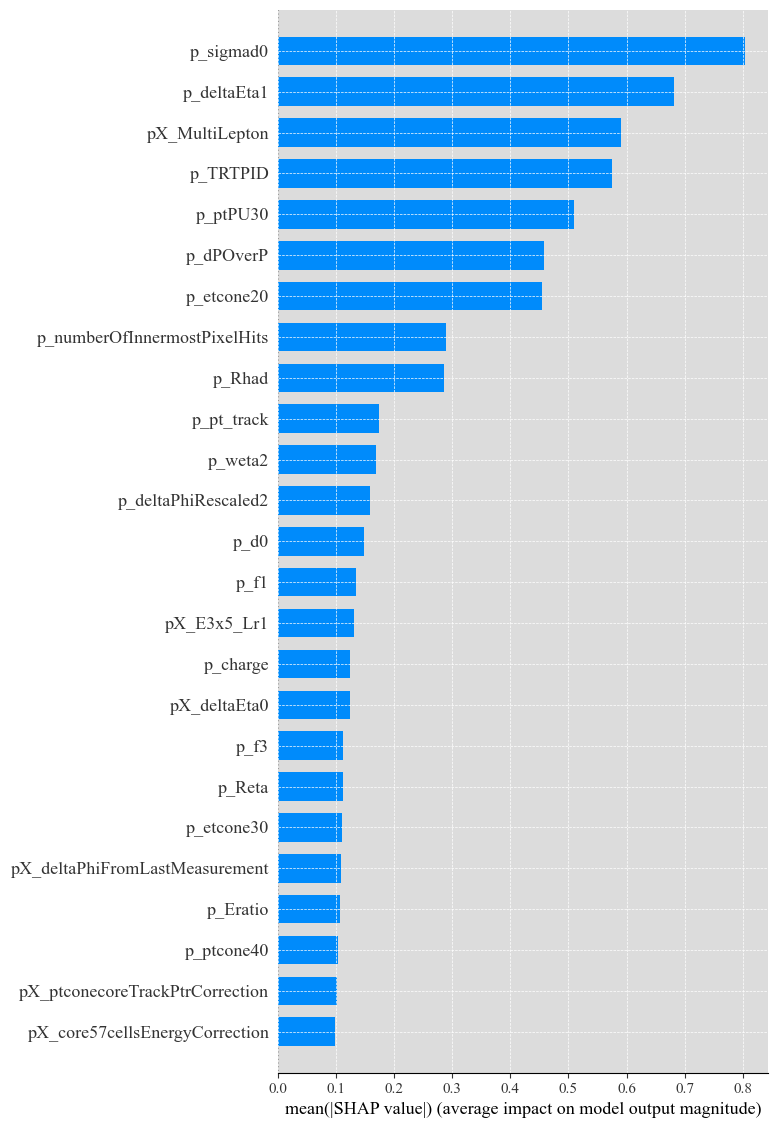

In [23]:
# SHAP values 
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(input_data)
shap.summary_plot(shap_values, 
                   input_data, 
                   feature_names=variables, 
                   max_display=25, 
                   plot_type="bar", 
                   color_bar=True,
)


In [33]:
# Permutation feature importance
from sklearn.inspection import permutation_importance

# Calculating the permutation importance (run if needed)
perm_importance = permutation_importance(model, x_valid, y_valid, n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()
sort_variables = np.array(variables)[sorted_idx][-25:]

# Save sort_variables as CSV file
pd.DataFrame(sort_variables).to_csv("handins/Classification_NielsDavidsen_LightGBMbdt_VariableList.csv", index=False, header=False)
pd.DataFrame(sort_variables).to_csv("handins/Classification_NielsDavidsen_TorchNN_VariableList.csv", index=False, header=False)



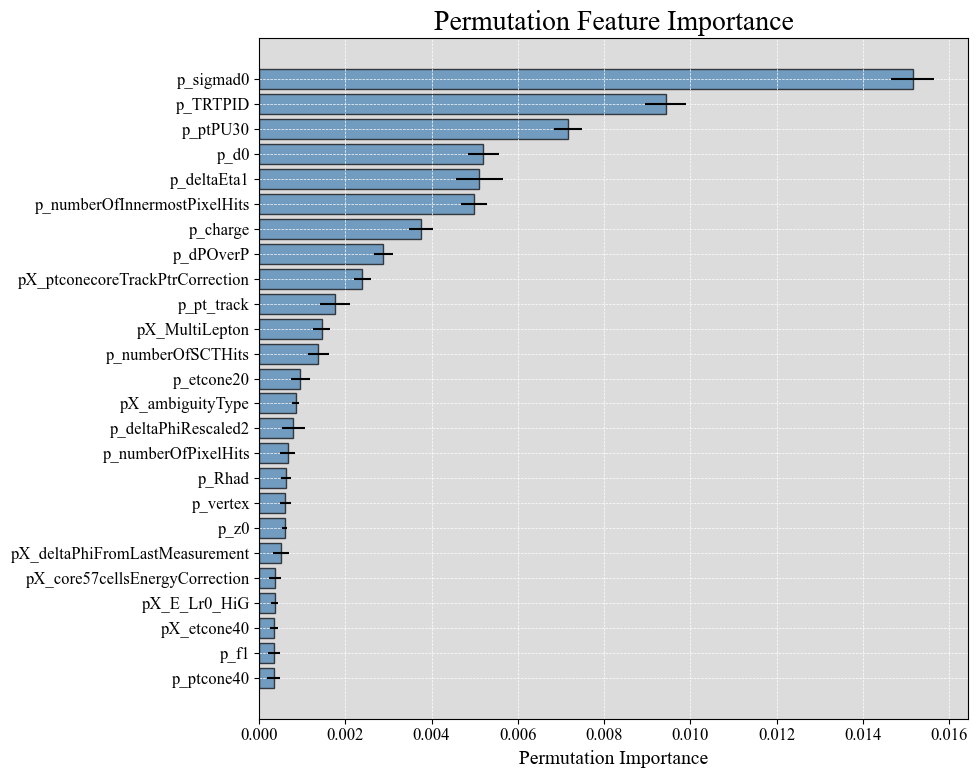

In [35]:
# Plot the permutation importance
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(sort_variables, perm_importance.importances_mean[sorted_idx][-25:], 
        xerr=perm_importance.importances_std[sorted_idx][-25:], 
        color="steelblue", 
        edgecolor="black", 
        alpha=0.7)
ax.set_xlabel("Permutation Importance")
ax.set_title("Permutation Feature Importance")
plt.tight_layout()
